### Detecção de Lesões de Câncer de Mama

### Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


In [66]:
# Imports
import os
import cv2
import numpy as np
import pandas as pd
import imageio
import skimage
import skimage.io
import skimage.transform
import tensorflow
import sklearn
import itertools
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from numpy.random import seed
seed(101)
%matplotlib inline

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Júlio Monteiro" --iversions

Author: Júlio Monteiro

matplotlib: 3.3.4
imageio   : 2.13.5
cv2       : 4.6.0
numpy     : 1.18.5
skimage   : 0.19.1
tensorflow: 2.3.1
pandas    : 1.0.3
sklearn   : 1.0.2



### Carregando os Dados

In [4]:
# Listando o conteúdo da pasta
pacientes = os.listdir('/media/datasets/IAMED/Cap05/IDC_regular_ps50_idx5')
# Número de pacientes
len(pacientes)

279

In [5]:
# Definindo o nome da pasta para as imagens
imagens_pacientes = 'imagens_pacientes'

In [6]:
# Removemos a pasta se existir. Se não existir, criamos.
if os.path.exists(imagens_pacientes):
    os.rmdir(imagens_pacientes)
    os.mkdir(imagens_pacientes)
else:
    os.mkdir(imagens_pacientes)

In [7]:
# Confirmando que a pasta foi criada
!ls

Cap05-Estudo-Caso2.ipynb  imagens_pacientes  modelo	    Untitled.ipynb
imagens			  __MACOSX	     tfjs_modelo_1


In [8]:
# Cria a lista de ids de pacientes
lista_ids_pacientes = os.listdir('/media/datasets/IAMED/Cap05/IDC_regular_ps50_idx5')

In [9]:
# Loop pelas pastas de pacientes para organizar as imagens em uma nova estrutura
for paciente in lista_ids_pacientes:
    
    # Definindo os caminhos das imagens
    path_0 = '/media/datasets/IAMED/Cap05/IDC_regular_ps50_idx5/' + str(paciente) + '/0'
    path_1 = '/media/datasets/IAMED/Cap05/IDC_regular_ps50_idx5/' + str(paciente) + '/1'

    # Lista de imagens da classe 0
    file_list_0 = os.listdir(path_0)
    
    # Lista de imagens da classe 1
    file_list_1 = os.listdir(path_1)

    # Movendo as imagens da classe 0
    for fname in file_list_0:
        origem = os.path.join(path_0, fname)
        destino = os.path.join(imagens_pacientes, fname)
        shutil.copyfile(origem, destino)

    # Movendo as imagens da classe 1
    for fname in file_list_1:
        origem = os.path.join(path_1, fname)
        destino = os.path.join(imagens_pacientes, fname)
        shutil.copyfile(origem, destino)

In [10]:
# Checando o total de imagens
len(os.listdir('imagens_pacientes'))

277524

### Pré-Processamento das Imagens
#### Preparando o Dataframe

In [11]:
# Lista de imagens
lista_imagens = os.listdir('imagens_pacientes')

In [12]:
# Visualizando uma amostra
lista_imagens[1:5]

['12822_idx5_x951_y551_class1.png',
 '12819_idx5_x1151_y601_class0.png',
 '10300_idx5_x3201_y401_class0.png',
 '12890_idx5_x451_y1801_class0.png']

In [13]:
# Convertendo a lista para dataframe
df_imagens = pd.DataFrame(lista_imagens, columns = ['id_imagem'])

In [14]:
# Visualiza
df_imagens.head()

,id_imagem
0,12868_idx5_x1501_y551_class0.png
1,12822_idx5_x951_y551_class1.png
2,12819_idx5_x1151_y601_class0.png
3,10300_idx5_x3201_y401_class0.png
4,12890_idx5_x451_y1801_class0.png


In [15]:
# Shape
df_imagens.shape

(277524, 1)

In [16]:
# Função para extrair o id do paciente
def extrai_id(x):
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id

In [17]:
# Função para extrair a classe
def extrai_classe(x):
    a = x.split('_')
    b = a[4]
    target = b[5]
    
    return target

In [18]:
# Extraindo o id do paciente
df_imagens['id_paciente'] = df_imagens['id_imagem'].apply(extrai_id)

In [19]:
# Extraindo a classe da imagem
df_imagens['classe'] = df_imagens['id_imagem'].apply(extrai_classe)

In [20]:
# Visualiza
df_imagens.head()

,id_imagem,id_paciente,classe
0,12868_idx5_x1501_y551_class0.png,12868,0
1,12822_idx5_x951_y551_class1.png,12822,1
2,12819_idx5_x1151_y601_class0.png,12819,0
3,10300_idx5_x3201_y401_class0.png,10300,0
4,12890_idx5_x451_y1801_class0.png,12890,0


In [21]:
# Shape
df_imagens.shape

(277524, 3)

### Visualizando Amostras das Imagens

In [22]:
# Função para o plot da imagem
def plot_imagens(col_name, figure_cols, df):
    
    # Categoriias
    categories = (df.groupby([col_name])[col_name].nunique()).index
    
    # Subplots
    f, ax = plt.subplots(nrows = len(categories), 
                         ncols = figure_cols, 
                         figsize = (4 * figure_cols, 4 * len(categories))) 
    
    # Loop pelas categorias
    for i, cat in enumerate(categories):
        
        # Amostra
        sample = df[df[col_name]==cat].sample(figure_cols) 
        
        # Loop pelas colunas
        for j in range(0, figure_cols):
            file = 'imagens_pacientes/' + sample.iloc[j]['id_imagem']
            im = cv2.imread(file)
            ax[i, j].imshow(im, resample = True, cmap = 'gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

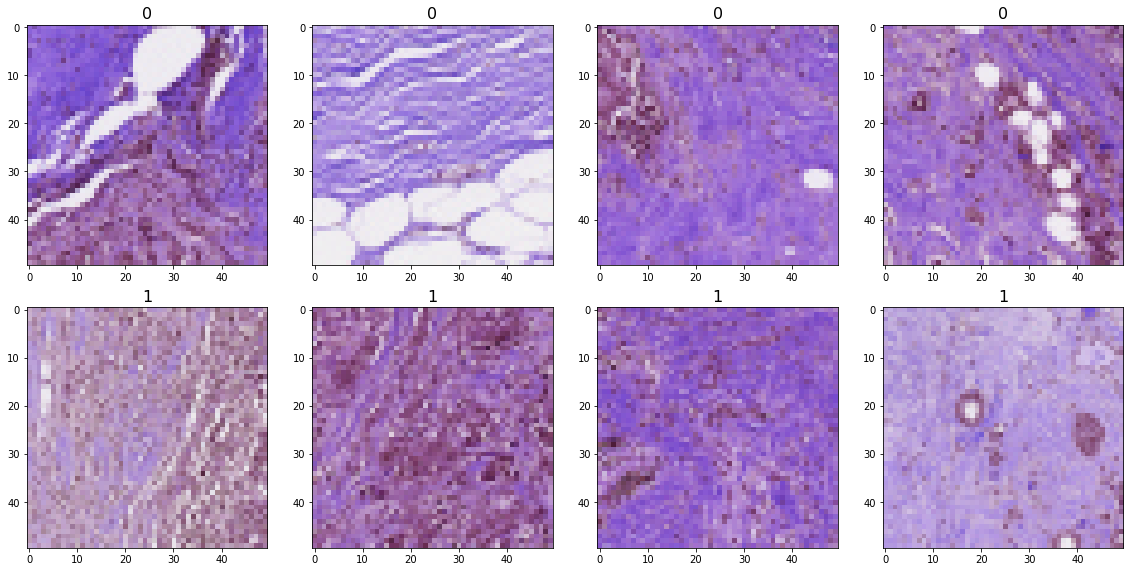

In [23]:
# Plot
plot_imagens('classe', 4, df_imagens)

In [24]:
# Checando o balanceamento de classe
df_imagens['classe'].value_counts()

0    198738
1     78786
Name: classe, dtype: int64

### Balanceamento das Classes

As classes estão desbalanceadas. Vamos resolver isso extraindo amostras aleatórias de imagens das duas classes. As amostras serão de mesmo tamanho e depois concatenamos o resultado.

Usaremos aqui a técnica de undersampling.

In [25]:
# Tamanho de amostra
SAMPLE_SIZE = 78786

In [26]:
# Extraindo amostra da classe majoritária
df_classe0 = df_imagens[df_imagens['classe'] == '0'].sample(SAMPLE_SIZE, random_state = 101)

In [27]:
# Extraindo amostra da classe minoritária
df_classe1 = df_imagens[df_imagens['classe'] == '1'].sample(SAMPLE_SIZE, random_state = 101)

In [28]:
# Concatenando os 2 dataframes
df_imagens = pd.concat([df_classe0, df_classe1], axis = 0).reset_index(drop = True)

In [29]:
# Checando o balanceamento de classe
df_imagens['classe'].value_counts()

0    78786
1    78786
Name: classe, dtype: int64

### Divisão em Dados de Treino, Validação e Teste

In [30]:
# Definimos a variável target y
y = df_imagens['classe']

In [31]:
# Divisão em treino e validação com proporção 85/15
df_imagens_treino, df_imagens_valid = train_test_split(df_imagens, 
                                                       test_size = 0.15, 
                                                       random_state = 101, 
                                                       stratify = y)

In [32]:
# Definimos a variável target y
y = df_imagens_treino['classe']

In [33]:
# Divisão em treino e teste com proporção 85/15
df_imagens_treino, df_imagens_test = train_test_split(df_imagens_treino, 
                                                       test_size = 0.20, 
                                                       random_state = 101, 
                                                       stratify = y)

#### Treinamento

In [34]:
# Verificamos o shape
print(df_imagens_treino.shape)

(107148, 3)


In [35]:
# Checando o balanceamento de classe
df_imagens_treino['classe'].value_counts()

0    53574
1    53574
Name: classe, dtype: int64

#### Validação

In [36]:
# Verificamos o shape
print(df_imagens_valid.shape)

(23636, 3)


In [37]:
# Checando o balanceamento de classe
df_imagens_valid['classe'].value_counts()

0    11818
1    11818
Name: classe, dtype: int64

#### Teste

In [38]:
# Verificamos o shape
print(df_imagens_test.shape)

(26788, 3)


In [39]:
# Checando o balanceamento de classe
df_imagens_test['classe'].value_counts()

0    13394
1    13394
Name: classe, dtype: int64

### Estrutura Final das Imagens Pré-Processadas

Por fim, precisamos preparar a estrutura de pasta das imagens para o treinamento do modelo.

In [40]:
# Criaremos a pasta base
pasta_base = 'pasta_base'

In [41]:
# Removemos a pasta se existir. Se não existir, criamos.
if os.path.exists(pasta_base):
    os.rmdir(pasta_base)
    os.mkdir(pasta_base)
else:
    os.mkdir(pasta_base)

In [42]:
# Agora criamos a pasta para as imagens de treino
imagens_treino = os.path.join(pasta_base, 'imagens_treino')

# Removemos a pasta se existir. Se não existir, criamos.
if os.path.exists(imagens_treino):
    os.rmdir(imagens_treino)
    os.mkdir(imagens_treino)
else:
    os.mkdir(imagens_treino)

In [43]:
# Estrutura dentro da pasta de treino
a_no_idc = os.path.join(imagens_treino, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(imagens_treino, 'b_has_idc')
os.mkdir(b_has_idc)

In [44]:
# Agora criamos a pasta para as imagens de validação
imagens_valid = os.path.join(pasta_base, 'imagens_valid')

# Removemos a pasta se existir. Se não existir, criamos.
if os.path.exists(imagens_valid):
    os.rmdir(imagens_valid)
    os.mkdir(imagens_valid)
else:
    os.mkdir(imagens_valid)

In [45]:
# Estrutura dentro da pasta de validação
a_no_idc = os.path.join(imagens_valid, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(imagens_valid, 'b_has_idc')
os.mkdir(b_has_idc)

In [46]:
# Agora criamos a pasta para as imagens de teste
imagens_test = os.path.join(pasta_base, 'imagens_test')

# Removemos a pasta se existir. Se não existir, criamos.
if os.path.exists(imagens_test):
    os.rmdir(imagens_test)
    os.mkdir(imagens_test)
else:
    os.mkdir(imagens_test)

In [47]:
# Estrutura dentro da pasta de teste
a_no_idc = os.path.join(imagens_test, 'a_no_idc')
os.mkdir(a_no_idc)
b_has_idc = os.path.join(imagens_test, 'b_has_idc')
os.mkdir(b_has_idc)

Podemos então transferir as imagens para as estruturas.

In [48]:
# Colocamos os ids como índice
df_imagens.set_index('id_imagem', inplace = True)

In [49]:
# Lista de imagens de treino, validação e teste
lista_treino = list(df_imagens_treino['id_imagem'])
lista_valid = list(df_imagens_valid['id_imagem'])
lista_test = list(df_imagens_test['id_imagem'])

In [50]:
# Transferimos as imagens de treino
for image in lista_treino:
    
    fname = image
    target = df_imagens.loc[image, 'classe']
    
    if target == '0':
        label = 'a_no_idc'
    if target == '1':
        label = 'b_has_idc'
    
    origem = os.path.join(imagens_pacientes, fname)
    destino = os.path.join(imagens_treino, label, fname)
    shutil.move(origem, destino)

In [51]:
# Transferimos as imagens de validação
for image in lista_valid:
    
    fname = image
    target = df_imagens.loc[image, 'classe']
    
    if target == '0':
        label = 'a_no_idc'
    if target == '1':
        label = 'b_has_idc'
    
    origem = os.path.join(imagens_pacientes, fname)
    destino = os.path.join(imagens_valid, label, fname)
    shutil.move(origem, destino)

In [52]:
# Transferimos as imagens de teste
for image in lista_test:
    
    fname = image
    target = df_imagens.loc[image, 'classe']
    
    if target == '0':
        label = 'a_no_idc'
    if target == '1':
        label = 'b_has_idc'
    
    origem = os.path.join(imagens_pacientes, fname)
    destino = os.path.join(imagens_test, label, fname)
    shutil.move(origem, destino)

### Configurando os Generators

In [116]:
# Variáveis para as pastas das imagens
train_path = 'pasta_base/imagens_treino'
valid_path = 'pasta_base/imagens_valid'
test_path = 'pasta_base/imagens_test'

In [117]:
# Números de amostras
num_train_samples = len(df_imagens_treino)
num_val_samples = len(df_imagens_valid)
num_test_samples = len(df_imagens_test)

In [118]:
# Tamanho do batch
train_batch_size = 8
val_batch_size = 8
test_batch_size = 1

In [119]:
# Número de steps
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
test_steps = np.ceil(num_test_samples / test_batch_size)

In [120]:
# Dimensão das imagens
IMAGE_SIZE = 50

In [121]:
# Data generator
datagen = ImageDataGenerator(rescale = 1.0/255)

In [122]:
# Data generator de treino
train_gen = datagen.flow_from_directory(train_path,
                                        target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                        batch_size = train_batch_size,
                                        class_mode = 'categorical')

Found 107148 images belonging to 2 classes.


In [123]:
# Data generator de validação
val_gen = datagen.flow_from_directory(valid_path,
                                      target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                      batch_size = val_batch_size,
                                      class_mode = 'categorical')

Found 23636 images belonging to 2 classes.


In [124]:
# Data generator de teste
test_gen = datagen.flow_from_directory(test_path,
                                       target_size = (IMAGE_SIZE, IMAGE_SIZE),
                                       batch_size = 1,
                                       class_mode = 'categorical',
                                       shuffle = False)

Found 26788 images belonging to 2 classes.


### Construção do Modelo

In [177]:
# Criamos o modelo base
modelo_base = tensorflow.keras.applications.VGG16(weights = 'imagenet', 
                                                include_top = False, 
                                                input_shape = (50,50,3))

In [178]:
# Sumário do modelo base
modelo_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [179]:
# Adicionamos nossas camadas ao modelo_base

# Cria a sequência de camadas
add_model = Sequential()

# Adiciona primeiro o modelo base
add_model.add(modelo_base)

# Precisamos de uma camada global de Pooling
add_model.add(GlobalAveragePooling2D())

# Dropout para regularização e evitar overfitting
add_model.add(Dropout(0.6))

# 1º Camada densa
add_model.add(Dense(16, activation = 'relu'))
add_model.add(Dropout(0.6))

# Camada de saida com ativação softmax para previsão das probabilidades das classes
add_model.add(Dense(2, activation = 'softmax'))

In [180]:
# Cria o modelo final
modelo_final = add_model

In [181]:
# Sumário do modelo final
modelo_final.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_10  (None, 512)               0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                8208      
_________________________________________________________________
dropout_21 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 34        
Total params: 14,722,930
Trainable params: 14,722,930
Non-trainable params: 0
_________________________________________

In [182]:
# Cria o otimizador
otimizador = Adam(lr = 0.0000001)

# Compilação do modelo
modelo_final.compile(optimizer = otimizador, 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [183]:
# Checkpoint para salvar o modelo
checkpoint = ModelCheckpoint('modelo/modelo.h5', 
                             monitor = 'val_loss', 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = 'min')

In [184]:
# Reduziremos a taxa de aprendizado
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.5, 
                              patience = 6, 
                              verbose = 1, 
                              mode = 'min', 
                              min_lr = 0.00000001)  

In [185]:
# Criamos a lista de callbacks
callbacks_list = [checkpoint, reduce_lr]

In [186]:
%%time
history = modelo_final.fit(train_gen, 
                     steps_per_epoch = train_steps, 
                     validation_data = val_gen,
                     validation_steps = val_steps,
                     epochs = 100, 
                     verbose = 1,
                     callbacks = callbacks_list)

Epoch 1/100
13390/13394 [============================>.] - ETA: 0s - loss: 0.7842 - accuracy: 0.5726
Epoch 00001: val_loss improved from inf to 0.57328, saving model to modelo/modelo.h5
13394/13394 [==============================] - 180s 13ms/step - loss: 0.7841 - accuracy: 0.5726 - val_loss: 0.5733 - val_accuracy: 0.7095
Epoch 2/100
13390/13394 [============================>.] - ETA: 0s - loss: 0.6409 - accuracy: 0.6440
Epoch 00002: val_loss improved from 0.57328 to 0.54007, saving model to modelo/modelo.h5
13394/13394 [==============================] - 180s 13ms/step - loss: 0.6409 - accuracy: 0.6441 - val_loss: 0.5401 - val_accuracy: 0.7368
Epoch 3/100
13392/13394 [============================>.] - ETA: 0s - loss: 0.5996 - accuracy: 0.6802
Epoch 00003: val_loss improved from 0.54007 to 0.51441, saving model to modelo/modelo.h5
13394/13394 [==============================] - 179s 13ms/step - loss: 0.5996 - accuracy: 0.6802 - val_loss: 0.5144 - val_accuracy: 0.7807
Epoch 4/100
13391/13

13394/13394 [==============================] - 179s 13ms/step - loss: 0.3960 - accuracy: 0.8341 - val_loss: 0.3464 - val_accuracy: 0.8500
Epoch 52/100
13391/13394 [============================>.] - ETA: 0s - loss: 0.3940 - accuracy: 0.8358
Epoch 00052: val_loss did not improve from 0.34638
13394/13394 [==============================] - 179s 13ms/step - loss: 0.3940 - accuracy: 0.8358 - val_loss: 0.3481 - val_accuracy: 0.8498
Epoch 53/100
13393/13394 [============================>.] - ETA: 0s - loss: 0.3913 - accuracy: 0.8368
Epoch 00053: val_loss did not improve from 0.34638
13394/13394 [==============================] - 179s 13ms/step - loss: 0.3913 - accuracy: 0.8368 - val_loss: 0.3465 - val_accuracy: 0.8511
Epoch 54/100
13394/13394 [==============================] - ETA: 0s - loss: 0.3928 - accuracy: 0.8373
Epoch 00054: val_loss improved from 0.34638 to 0.34543, saving model to modelo/modelo.h5
13394/13394 [==============================] - 179s 13ms/step - loss: 0.3928 - accuracy: 

### Avaliação do Modelo

In [187]:
# Obtém a lista de métricas disponíveis
modelo_final.metrics_names

['loss', 'accuracy']

In [188]:
# Carrega o modelo treinado
modelo_final.load_weights('modelo/modelo.h5')

In [189]:
# Extrai o erro e a acurácia
val_loss, val_acc = modelo_final.evaluate(test_gen, steps = len(df_imagens_valid))

23636/23636 [==============================] - 107s 5ms/step - loss: 0.3429 - accuracy: 0.8520


In [190]:
# Print
print('Erro:', val_loss)
print('Acurácia:', val_acc)

Erro: 0.3429187536239624
Acurácia: 0.8519631028175354


<Figure size 432x288 with 0 Axes>

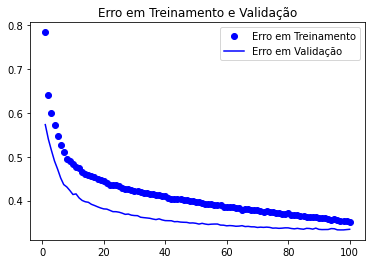

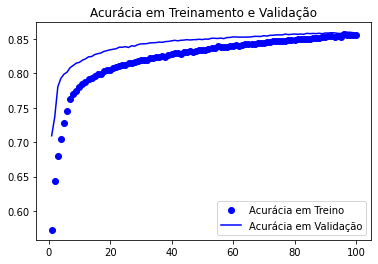

<Figure size 432x288 with 0 Axes>

In [191]:
# Plot das métricas
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label = 'Erro em Treinamento')
plt.plot(epochs, val_loss, 'b', label = 'Erro em Validação')
plt.title('Erro em Treinamento e Validação')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label = 'Acurácia em Treino')
plt.plot(epochs, val_acc, 'b', label = 'Acurácia em Validação')
plt.title('Acurácia em Treinamento e Validação')
plt.legend()
plt.figure()

### Fazendo Previsões

In [200]:
# Fazendo previsões
previsoes = modelo_final.predict(test_gen, steps = len(df_imagens_test), verbose = 1)

26788/26788 [==============================] - 68s 3ms/step


In [201]:
# Shape
previsoes.shape

(26788, 2)

In [202]:
# Aqui verificamos qual índice o Keras atribuiu internamente a cada classe
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

In [203]:
# Converte as previsões em dataframes
df_preds = pd.DataFrame(previsoes, columns = ['no_idc', 'has_idc'])
df_preds.head()

,no_idc,has_idc
0,0.772649,0.227351
1,0.999836,0.000164
2,0.963460,0.036541
3,0.133901,0.866099
4,0.288549,0.711451


In [204]:
# Obtém os labels
y_true = test_gen.classes

In [205]:
# Obtém as previsões como probabilidades
y_pred = df_preds['has_idc']

In [206]:
# Score AUC
roc_auc_score(y_true, y_pred)

0.9327575174288926

In [222]:
# Função do Plot da CM
def plot_confusion_matrix(cm, 
                          classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap  =plt.cm.Blues):

    #if normalize:
        #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Matriz de Confusão Normalizada")
   # else:
        #print('Matriz de Confusão Não Normalizada')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment = "center", 
                 color = "white" if cm[i, j] > thresh else "black")

    plt.ylabel('Classe Original')
    plt.xlabel('Classe Prevista')
    plt.tight_layout()

In [223]:
# Obtém os labels
test_labels = test_gen.classes

In [224]:
# Shape
test_labels.shape

(26788,)

In [225]:
# Retorna o índice da maior probabilidade
cm = confusion_matrix(test_labels, previsoes.argmax(axis = 1))

In [226]:
# Print 
test_gen.class_indices

{'a_no_idc': 0, 'b_has_idc': 1}

In [227]:
# Define os labels
cm_plot_labels = ['no_idc', 'has_idc']

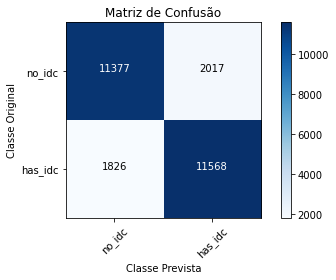

In [228]:
# Plot
plot_confusion_matrix(cm, cm_plot_labels, title = 'Matriz de Confusão')

In [229]:
# Relatório de classificação
y_pred_binary = previsoes.argmax(axis = 1)
report = classification_report(y_true, y_pred_binary, target_names = cm_plot_labels)
print(report)

              precision    recall  f1-score   support

      no_idc       0.86      0.85      0.86     13394
     has_idc       0.85      0.86      0.86     13394

    accuracy                           0.86     26788
   macro avg       0.86      0.86      0.86     26788
weighted avg       0.86      0.86      0.86     26788



### Prepara o Modelo Para o Deploy

In [5]:
# Instala o TensorFlow.js
!pip install -q tensorflowjs

In [6]:
# Converte o modelo do formato Keras para TensorFlow.js
!tensorflowjs_converter --input_format keras modelo/modelo.h5 tfjs_modelo_1/modelo

2022-07-25 05:58:28.264163: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
